# Feedforward Neural Network in Pure JAX with PyTorch Dataset

This tutorial demonstrates how to build, train, and evaluate a simple feedforward neural network (MLP) **from scratch** in JAX, using a real-world dataset from PyTorch (e.g., MNIST or FashionMNIST).

**Goals:**
- Use PyTorch DataLoader for batching and shuffling
- Write all neural network, loss, and optimizer code in “pure” JAX (no Flax/Optax)
- Train and evaluate the model

---

## 1. Setup

Install dependencies if needed:

In [2]:
#pip install jax jaxlib torch torchvision matplotlib

In [15]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import random
from jax.example_libraries import optimizers

## 2. Data Loading with PyTorch

We'll use `torchvision.datasets` for loading and normalizing MNIST, then batch with a DataLoader.

**Explanation:**
- We use PyTorch's MNIST dataset and DataLoader for easy batching/shuffling.
- `ToTensor()` converts PIL images to float32 tensors, scaled to [0,1].
- `Lambda(lambda x: x.view(-1))` flattens the 28x28 image to a vector of length 784, as our MLP expects flat inputs.
- `train_loader` and `test_loader` will yield batches of images and labels, which we'll convert to JAX arrays inside the training loop.


In [3]:


# Transform: torchvision returns PIL Images, so convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [0,1] float32 tensor
    transforms.Lambda(lambda x: x.view(-1)),  # Flatten 28x28 -> 784
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

100%|█████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:02<00:00, 4.30MB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 215kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 1.22MB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 7.16MB/s]




## 3. Neural Network and Utilities in Pure JAX

**Detailed Explanation:**

- **init_params(key, layer_sizes):**
    - Initializes the weights and biases for each layer of the network.
    - `layer_sizes` is a list like `[784, 256, 128, 10]` (input, two hidden, output).
    - For each layer, we:
        - Generate weights `w` (with He initialization) of shape `(in_dim, out_dim)`
        - Generate biases `b` of shape `(out_dim,)`, initialized to zeros.
    - Returns a list of `(w, b)` tuples, one for each layer.

- **mlp(params, x):**
    - Runs a forward pass of the MLP.
    - `params` is the list of `(w, b)` pairs from `init_params`.
    - For all layers except the last, we compute:
        - Matrix multiply + bias: `x @ w + b`
        - Apply ReLU activation: `jnp.maximum(x, 0)`
    - For the last layer, just compute the logits (no activation).
    - Returns the logits (unnormalized scores for each class).

- **accuracy(params, x, y):**
    - Computes the predicted class for each input by taking `argmax` over logits.
    - Compares predictions to true labels and returns the mean (i.e., batch accuracy).

---


In [5]:
# Model definition: 2 hidden layers, ReLU, output logits for 10 classes
def init_params(key, layer_sizes):
    keys = random.split(key, len(layer_sizes))
    params = []
    for k, (in_dim, out_dim) in zip(keys, zip(layer_sizes[:-1], layer_sizes[1:])):
        w = random.normal(k, (in_dim, out_dim)) * jnp.sqrt(2.0 / in_dim)
        b = jnp.zeros(out_dim)
        params.append((w, b))
    return params


In [6]:
def mlp(params, x):
    for w, b in params[:-1]:
        x = jnp.dot(x, w) + b
        x = jnp.maximum(x, 0)  # ReLU
    w, b = params[-1]
    logits = jnp.dot(x, w) + b
    return logits

def accuracy(params, x, y):
    logits = mlp(params, x)
    preds = jnp.argmax(logits, axis=1)
    return (preds == y).mean()

## 4. Loss Function


**Detailed Explanation:**
- Computes the cross-entropy loss between the network's predicted logits and the true labels.
- `jax.nn.log_softmax(logits)` is numerically stable.
- For each sample in the batch, select the log probability of the correct class (`log_probs[range, y]`), then take the negative mean (as per standard cross-entropy).

---

# What Are Logits? Meaning, Utility, and Origin

## What Are Logits?

**Logits** are the unnormalized output values produced by the last layer of a neural network, typically before applying an activation function such as softmax or sigmoid.  
They are real-valued numbers (can be positive or negative, any magnitude) representing the "raw" predictions or scores for each class.

### Example

For a 10-class classification problem (like MNIST), your network might output a vector like:

```
logits = [2.1, -1.3, 0.7, ..., 0.2]
```

Each value in this vector is a **logit** for the corresponding class.

---

## Why Are Logits Useful?

### 1. **Numerical Stability**

- Many loss functions (like cross-entropy) are more numerically stable when computed using logits directly.
- Instead of converting logits to probabilities (via softmax) and then taking the log, most frameworks (like JAX, PyTorch, TensorFlow) provide functions like `log_softmax` or `cross_entropy_with_logits` that combine these steps for accuracy and efficiency.

### 2. **Interpretability**

- Logits encode the “confidence” of the model in a raw, linear scale.
- The difference between logits for two classes reflects how much more confident the model is in one class over another.

### 3. **Flexibility**

- You can easily convert logits to probabilities for interpretation or visualization:
    - For multi-class: `softmax(logits)` → probabilities that sum to 1.
    - For binary: `sigmoid(logits)` → probability between 0 and 1.

### 4. **Gradient Flow**

- Using logits directly allows for better gradient flow during backpropagation, avoiding saturation that can occur if you use probabilities early.

---

## Where Do Logits Come From? (Origin)

- The term **logit** comes from statistics, specifically **log-odds**.
- For binary classification, the logit is the logarithm of the odds that an event occurs:
    - `logit(p) = log(p / (1 - p))`
    - Here, `p` is the probability of a class.
- In neural networks, the final linear layer outputs logits, which are then typically converted to probabilities using softmax (for multi-class) or sigmoid (for binary).

---

## Typical Workflow in Modern Deep Learning

1. **Model produces logits** (e.g., shape `[batch_size, num_classes]`)
2. **Loss function** (like cross-entropy) operates on logits directly—no need to convert to probabilities first.
3. **When needed for interpretation or reporting**, apply softmax or sigmoid to get probabilities.

---

## Example in JAX

```python
logits = mlp(params, x)               # Raw outputs (logits)
probs = jax.nn.softmax(logits, axis=1)  # Probabilities for each class
```

---

## Summary Table

| Term     | Description                                  | Example Value  |
|----------|----------------------------------------------|---------------|
| Logit    | Unnormalized score, real number              |     2.3       |
| Probability | Softmax/sigmoid of logit (between 0 and 1) |     0.91      |

---

## In Practice

- **Always output logits from your model.**
- **Use loss functions that expect logits (not probabilities).**
- **Only use probabilities for interpretation, visualization, or thresholding.**

---

In [11]:

def cross_entropy_loss(params, x, y):
    logits = mlp(params, x)
    log_probs = jax.nn.log_softmax(logits)
    return -log_probs[jnp.arange(y.shape[0]), y].mean()
 


## 5. Training Loop with JAX Optimizers (Adam)

 **Detailed Explanation:**

- **Hyperparameters and Initialization:**
    - `layer_sizes`: Sets architecture (input, hidden, output sizes).
    - `lr`: Learning rate for Adam.
    - `epochs`: How many times to go through the full dataset.
    - `seed`: For reproducibility.
    - `params`: Initial network weights/biases.
    - Adam optimizer is set up using JAX's `optimizers.adam()`, which provides three functions:
        - `opt_init`: Initializes optimizer state.
        - `opt_update`: Updates the optimizer state given gradients.
        - `get_params`: Gets the current parameters from the optimizer state.

- **@jax.jit def update(step, opt_state, x, y):**
    - JIT-compiled function for speed.
    - Gets current parameters, computes loss and gradients with `jax.value_and_grad`.
    - Updates the optimizer state using Adam with the computed gradients.
    - Returns new optimizer state and the current loss.

- **Training Loop:**
    - For each epoch:
        - For each batch from the DataLoader:
            - Convert PyTorch tensors to JAX arrays.
            - Call `update()` to perform one optimizer step.
            - Track and print batch/epoch losses for monitoring.
    - After training, extract the final model parameters from the optimizer state.

---


In [13]:

# Hyperparameters
layer_sizes = [784, 128, 128, 10]
lr = 1e-3
epochs = 5
seed = 42

key = random.PRNGKey(seed)
params = init_params(key, layer_sizes)

# Setup Adam optimizer from jax.experimental.optimizers
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)

@jax.jit
def update(step, opt_state, x, y):
    params = get_params(opt_state)
    loss, grads = jax.value_and_grad(cross_entropy_loss)(params, x, y)
    opt_state = opt_update(step, grads, opt_state)
    return opt_state, loss

step = 0
for epoch in range(epochs):
    train_losses = []
    batch_count = 0
    for xb, yb in train_loader:
        xb = jnp.array(xb.numpy())
        yb = jnp.array(yb.numpy()).astype(jnp.int32)
        opt_state, loss = update(step, opt_state, xb, yb)
        step += 1
        batch_count += 1
        train_losses.append(loss)
        if batch_count % 100 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_count}, Batch Loss: {loss:.4f}")
    print(f"Epoch {epoch+1}, Train Loss: {jnp.mean(jnp.array(train_losses)):.4f}")

params = get_params(opt_state)

Epoch 1, Batch 100, Batch Loss: 0.2106
Epoch 1, Batch 200, Batch Loss: 0.2952
Epoch 1, Batch 300, Batch Loss: 0.2503
Epoch 1, Batch 400, Batch Loss: 0.4530
Epoch 1, Train Loss: 0.3071
Epoch 2, Batch 100, Batch Loss: 0.1661
Epoch 2, Batch 200, Batch Loss: 0.1212
Epoch 2, Batch 300, Batch Loss: 0.1149
Epoch 2, Batch 400, Batch Loss: 0.0786
Epoch 2, Train Loss: 0.1238
Epoch 3, Batch 100, Batch Loss: 0.0398
Epoch 3, Batch 200, Batch Loss: 0.1032
Epoch 3, Batch 300, Batch Loss: 0.0410
Epoch 3, Batch 400, Batch Loss: 0.0574
Epoch 3, Train Loss: 0.0847
Epoch 4, Batch 100, Batch Loss: 0.0428
Epoch 4, Batch 200, Batch Loss: 0.0441
Epoch 4, Batch 300, Batch Loss: 0.0364
Epoch 4, Batch 400, Batch Loss: 0.0317
Epoch 4, Train Loss: 0.0650
Epoch 5, Batch 100, Batch Loss: 0.0700
Epoch 5, Batch 200, Batch Loss: 0.0789
Epoch 5, Batch 300, Batch Loss: 0.0428
Epoch 5, Batch 400, Batch Loss: 0.1833
Epoch 5, Train Loss: 0.0495


## 6. Evaluation

 **Detailed Explanation:**
- For each test batch:
    - Convert data to JAX arrays.
    - Compute the accuracy for the batch using the final trained parameters.
    - Collect all batch accuracies.
- Print the average accuracy over the entire test set.


In [14]:
test_accs = []
for xb, yb in test_loader:
    xb = jnp.array(xb.numpy())
    yb = jnp.array(yb.numpy()).astype(jnp.int32)
    acc = accuracy(params, xb, yb)
    test_accs.append(acc)
print(f"Test Accuracy: {jnp.mean(jnp.array(test_accs)) * 100:.2f}%")

Test Accuracy: 97.67%


## Visualization


**Detailed Explanation:**
- Take the first batch from the test loader.
- Run the model on this batch and compute predicted classes.
- Plot the first 10 images, with predicted labels as titles, to see some model outputs visually.

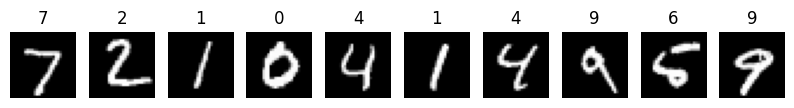

In [16]:

xb, yb = next(iter(test_loader))
xb = jnp.array(xb.numpy())
yb = jnp.array(yb.numpy()).astype(jnp.int32)
logits = mlp(params, xb)
preds = jnp.argmax(logits, axis=1)

plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(xb[i].reshape(28,28), cmap="gray")
    plt.axis('off')
    plt.title(int(preds[i]))
plt.show()

## 8. Summary

- **Data:** PyTorch DataLoader, easily converted to JAX arrays
- **Model:** Feedforward MLP in pure JAX
- **Optimizer:** JAX's Adam optimizer from `jax.example_libraries.optimizers`
- **Training:** Fast, compiled with JAX's `jit`
- **Evaluation:** Simple, vectorized accuracy calculation

**Next steps:**  
- For more features/flexibility, move to Flax + Optax  
- This approach lets you use any PyTorch dataset with JAX models!